# Student Performance Bayesian Network

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC, TreeSearch
from pgmpy.readwrite import BIFReader, BIFWriter
from pgmpy.inference import VariableElimination

Data from the [UCI Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance) dataset

In [73]:
# Importing data
df = pd.read_csv("data/student-mat.csv", sep=";")

## Models

### Constraint-based: PC algorithm

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THRE

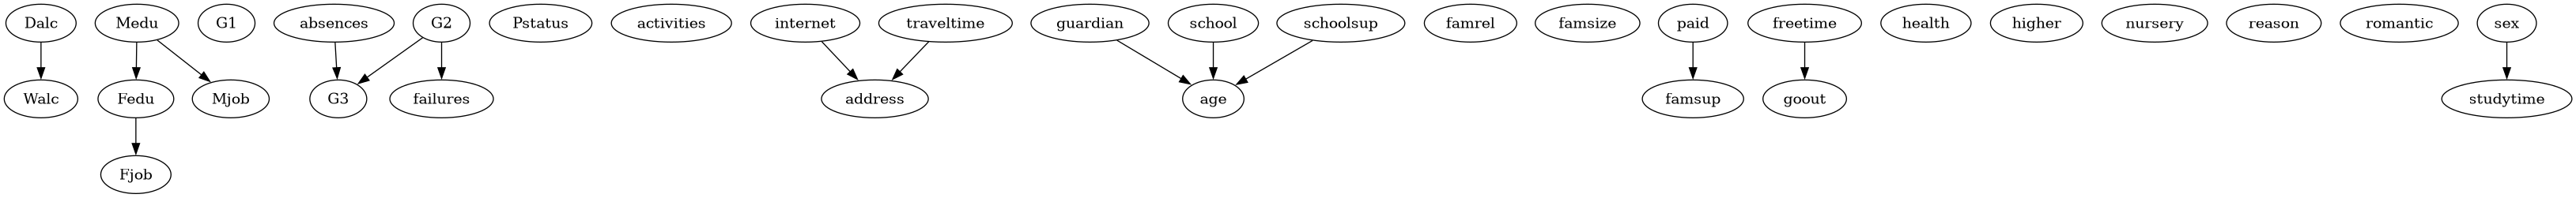

In [74]:
# Solving issue of non reproducibility of the PC network by storing the network and loading it at need
try:
    reader = BIFReader(path="models/pc-bn.bif")
    # Network already exist, loading network
    pc_bn = reader.get_model()
except FileNotFoundError:  # Network does not exist yet
    pc_dag = PC(df).estimate(return_type="dag", significance_level=0.05)  # PC algorithm
    # Initializing bayesian network from DAG
    pc_bn = BayesianNetwork()
    pc_bn.add_nodes_from(pc_dag.nodes())
    pc_bn.add_edges_from(pc_dag.edges())

    pc_bn.fit(df)

    # Storing newly created network
    writer = BIFWriter(pc_bn)
    writer.write_bif(filename="models/pc-bn.bif")

# Plotting and storing network
pc_bn_graphviz = pc_bn.to_graphviz()
pc_bn_graphviz.draw("img/pc-bn.png", prog="dot")
Image(filename="img/pc-bn.png")

### Score-based: Tree Search

Building tree:   0%|          | 0/528.0 [00:00<?, ?it/s]

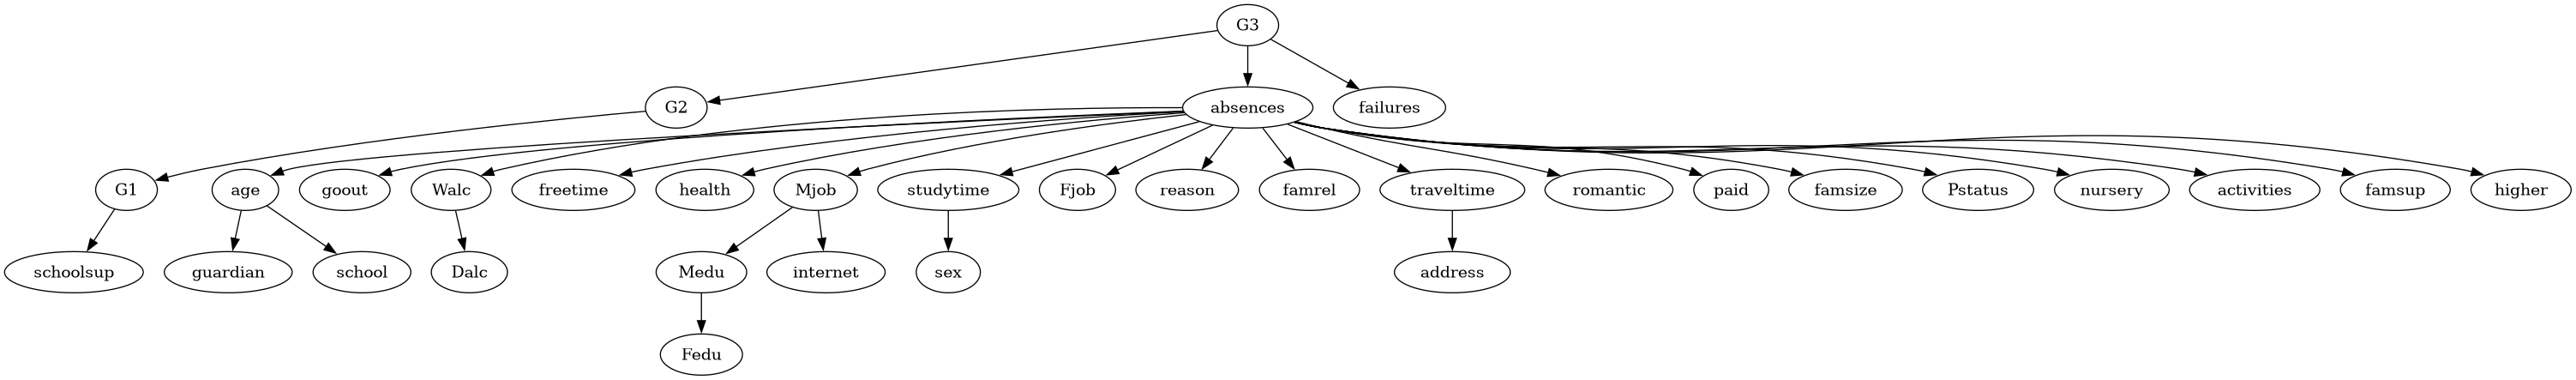

In [75]:
tree_dag = TreeSearch(df).estimate()  # Tree search

# Initializing bayesian network from DAG
tree_bn = BayesianNetwork()
tree_bn.add_nodes_from(tree_dag.nodes())
tree_bn.add_edges_from(tree_dag.edges())

# Plotting and storing network
tree_bn_graphviz = tree_bn.to_graphviz()
tree_bn_graphviz.draw("img/tree-bn.png", prog="dot")
Image(filename="img/tree-bn.png")

In [76]:
tree_bn.fit(df)
writer = BIFWriter(tree_bn)
writer.write_bif(filename="models/tree-bn.bif")

### Expert defined

In [77]:
# Unique value count for each feature
df.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

Dropping features considered not highly relevant:
- school, reason: assuming student performances equivalent in different schools.
- address: home address type not considered relevant.
- famsize, guardian: family info already contained in other variables.
- nursery: attending nursery school not considered as relevant.
- G1, G2: interested only in the final grade.
    

In [78]:
expert_df = df.drop(
    [
        "school",
        "reason",
        "address",
        "famsize",
        "guardian",
        "paid",
        "nursery",
        "G1",
        "G2",
    ],
    axis=1,
)
expert_df.head()

,sex,age,Pstatus,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,F,18,A,4,4,at_home,teacher,2,2,0,...,no,no,4,3,4,1,1,3,6,6
1,F,17,T,1,1,at_home,other,1,2,0,...,yes,no,5,3,3,1,1,3,4,6
2,F,15,T,1,1,at_home,other,1,2,3,...,yes,no,4,3,2,2,3,3,10,10
3,F,15,T,4,2,health,services,1,3,0,...,yes,yes,3,2,2,1,1,5,2,15
4,F,16,T,3,3,other,other,1,2,0,...,no,no,4,3,2,1,2,5,4,10


Aggregating features and values so to have smaller CPTs at the loss of some information detail

In [79]:
# Aggregating features: Considering student as socially active if they have a romantic partner or they meet friends regularly
expert_df["socially_active"] = (expert_df["romantic"] == "yes") | (
    expert_df["goout"] > 2
)
expert_df = expert_df.drop(["romantic", "goout"], axis=1)

In [80]:
# Making parents' education a boolean feature: True it's on par with the child's education (highschool) or greater, False otherwise
expert_df["Medu"] = expert_df["Medu"] >= 3
expert_df["Fedu"] = expert_df["Fedu"] >= 3

In [81]:
# Changing parents' job features to employed boolean features
expert_df["Mjob"] = expert_df["Mjob"] != "at_home"
expert_df["Fjob"] = expert_df["Fjob"] != "at_home"

In [82]:
# Re-binning absences to 0, 1, and 2 corresponding respectively to "Low", "Medium", "Hight"
def rebin_absences(x):
    if x < 10:  # Low number of absences
        return 0
    elif x < 20:  # Medium number of absences
        return 1
    else:  # High number of absences
        return 2


expert_df["absences"] = expert_df["absences"].apply(rebin_absences)

In [83]:
# Re-binning final grade column
def rebin_G3(x):
    if x < 10:  # Insufficient
        return 0
    elif x < 14:  # Sufficient
        return 1
    elif x < 18:  # Good
        return 2
    else:  # Excellent
        return 3


expert_df["G3"] = expert_df["G3"].apply(rebin_G3)

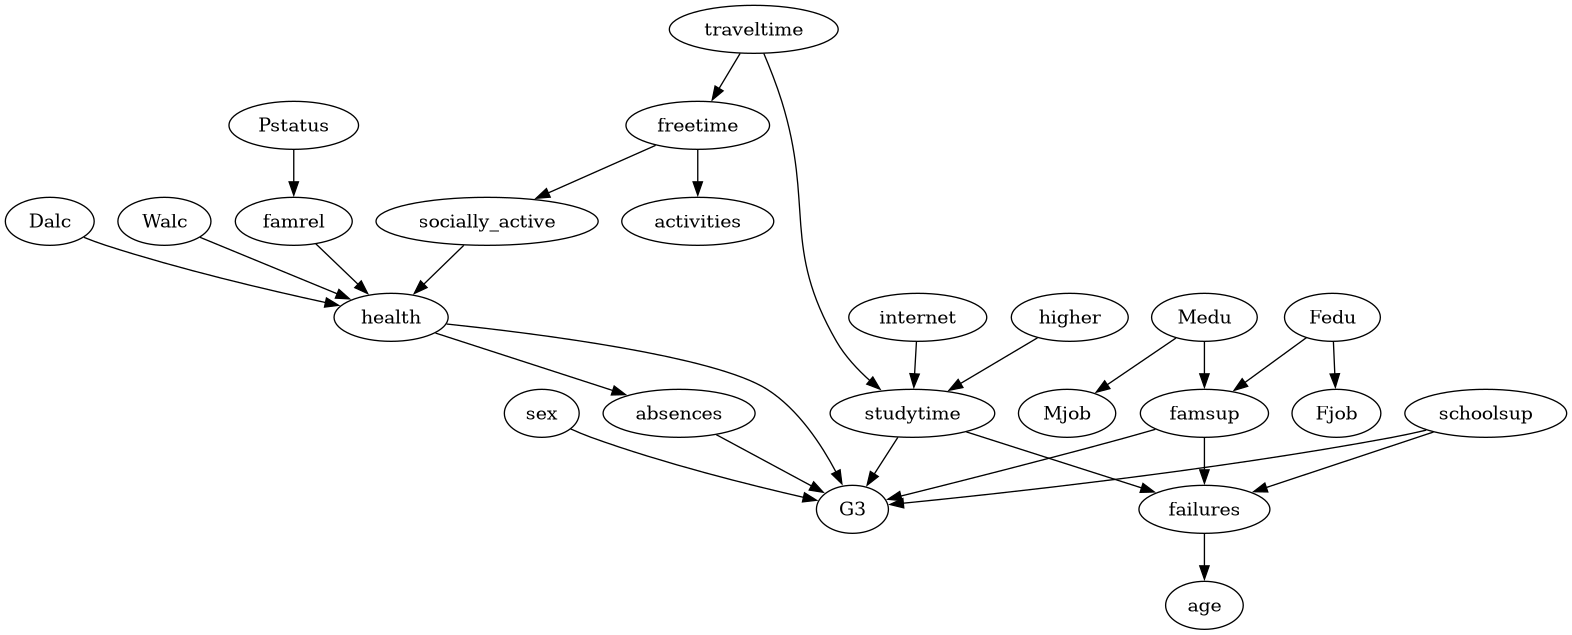

In [84]:
expert_bn = BayesianNetwork(
    [
        ("Pstatus", "famrel"),
        ("Medu", "Mjob"),
        ("Medu", "famsup"),
        ("Fedu", "Fjob"),
        ("Fedu", "famsup"),
        ("famsup", "failures"),
        ("schoolsup", "failures"),
        ("failures", "age"),
        ("famsup", "G3"),
        ("schoolsup", "G3"),
        ("traveltime", "studytime"),
        ("traveltime", "freetime"),
        ("internet", "studytime"),
        ("studytime", "failures"),
        ("studytime", "G3"),
        ("freetime", "socially_active"),
        ("freetime", "activities"),
        ("socially_active", "health"),
        ("health", "G3"),
        ("health", "absences"),
        ("absences", "G3"),
        ("Dalc", "health"),
        ("Walc", "health"),
        ("famrel", "health"),
        ("higher", "studytime"),
        ("sex", "G3"),
    ]
)

expert_bn_graphviz = expert_bn.to_graphviz()
expert_bn_graphviz.draw("img/expert-bn.png", prog="dot")
Image(filename="img/expert-bn.png")

In [85]:
expert_bn.fit(expert_df)
writer = BIFWriter(expert_bn)
writer.write_bif(filename="models/expert-bn.bif")

## Comparing the number of edges and the number of CPT entries

In [86]:
# Returns count of all the values stored in the CPDs of a network
# NOTE: pgmpy stores the full table
def count_network_cpt_entries(bayes_net: BayesianNetwork):
    entries_count = 0
    for cpd in bayes_net.get_cpds():  # cpd is a TabularCPD object
        entries_count += cpd.values.size
    return entries_count

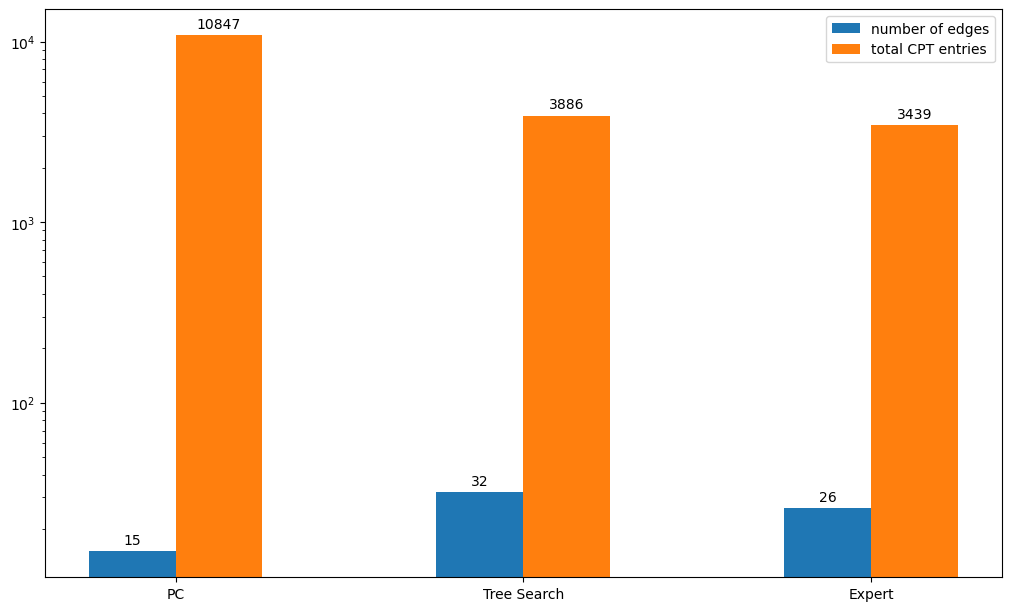

In [87]:
# Bar plot
networks = ("PC", "Tree Search", "Expert")
results = {
    "number of edges": (
        len(pc_bn.edges()),
        len(tree_bn.edges()),
        len(expert_bn.edges()),
    ),
    "total CPT entries": (
        count_network_cpt_entries(pc_bn),
        count_network_cpt_entries(tree_bn),
        count_network_cpt_entries(expert_bn),
    ),
}
x = np.arange(len(networks))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(10, 6))

for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width / 2, networks)
ax.set_yscale("log")
ax.legend()

plt.savefig("img/structure-comparison.png")
plt.show()

The reason for such a high number of CPT entries in the sparse, PC generated, Bayesian network are the edges between the high cardinality variables absences, G2, G3:

In [88]:
print(f"The CPT for the G3 variable holds {pc_bn.get_cpds("G3").values.size} entries")

The CPT for the G3 variable holds 10404 entries


## Absences and studytime

In order to have a better chance of achieving a higher final grade, is it better to have less absences at the cost of less study time or is it better to have more absences but more study time ? That is to say: $$\mathbb{P}(G3 \geq good | absences = low, studytime = average) \gtrless \mathbb{P}(G3 \geq good) | absences = medium, studytime = high)$$  

- For the non re-binned networks:
    $$\mathbb{P}(G3 \in \{15..20\}) | absences \in \{0..9\}, studytime = 3) \gtrless \mathbb{P}(G3 \in \{15..20\} | absences \in \{10..19\}, studytime = 4)$$
    Events G3 = 15, G3 = 16, ... , G3 = 20 are disjoint:
    $$ \sum_{i = 15}^{20} \mathbb{P}(G3 = i | absences \in \{0..9\}, studytime=3) \gtrless \sum_{i = 15}^{20} \mathbb{P}(G3 = i | absences \in \{10..19\}, studytime=4)$$
    From the conditional probability definition:
    $$\sum_{i = 15}^{20} \frac{\mathbb{P}(G3 = i, absences \in \{0..9\}, studytime=3)}{\mathbb{P}(absences \in \{0..9\}, studytime=3)} \gtrless \sum_{i = 15}^{20} \frac{\mathbb{P}(G3 = i, absences \in \{10..19\}, studytime=4)}{\mathbb{P}(absences \in \{10..19\}, studytime=4)}$$
    Events absences = j and absences = k are disjoint $\forall j, k, j \neq k$:
    $$\sum_{i = 15}^{20} \left( \frac{\sum_{j=0}^{9} \mathbb{P}(G3=i, absences=j, studytime=3)}{\sum_{j=0}^{9} \mathbb{P}(absences = j, studytime = 3)} \right)\gtrless \sum_{i = 15}^{20}\left( \frac{\sum_{j=10}^{19} \mathbb{P}(G3=i, absences=j, studytime=4)}{\sum_{j=10}^{19} \mathbb{P}(absences = j, studytime = 4)} \right)$$
    Applying the chain rule:
    $$\sum_{i = 15}^{20} \left( \frac{\sum_{j=0}^{9} \mathbb{P}(G3=i | absences = j, studytime = 3) \mathbb{P}(absences = j | studytime = 3)\mathbb{P}(studytime = 3)}{\sum_{j=0}^{9} \mathbb{P}(absences = j | studytime = 3) \mathbb{P}(studytime = 3)} \right) \\ \gtrless \sum_{i = 15}^{20} \left( \frac{\sum_{j=10}^{19} \mathbb{P}(G3=i | absences = j, studytime = 4) \mathbb{P}(absences = j | studytime = 4 )\mathbb{P}(studytime = 4)}{\sum_{j=10}^{19} \mathbb{P}(absences = j | studytime = 4) \mathbb{P}(studytime = 4)} \right)$$
    Canceling out $\mathbb{P}(studytime)$
    $$ \frac{\sum_{i = 15}^{20} \sum_{j=0}^{9} \mathbb{P}(G3=i | absences = j, studytime = 3) \mathbb{P}(absences = j | studytime = 3)}{\sum_{j=0}^{9} \mathbb{P}(absences = j | studytime = 3)} \gtrless \frac{\sum_{i = 15}^{20} \sum_{j=10}^{19} \mathbb{P}(G3=i | absences = j, studytime = 4) \mathbb{P}(absences = j | studytime = 4 )}{\sum_{j=10}^{19} \mathbb{P}(absences = j | studytime = 4)}$$
    Swapping summation order:
    $$\frac{\sum_{j=0}^{9} \left( \mathbb{P}(absences = j | studytime = 3) \sum_{i = 15}^{20} \mathbb{P}(G3=i | absences = j, studytime = 3) \right)}{\sum_{j=0}^{9} \mathbb{P}(absences = j | studytime = 3)} \gtrless \frac{\sum_{j=10}^{19} \left( \mathbb{P}(absences = j | studytime = 4) \sum_{i = 15}^{20} \mathbb{P}(G3=i | absences = j, studytime = 4) \right)}{\sum_{j=10}^{19} \mathbb{P}(absences = j | studytime = 3)}$$

- For the re-binned network:
    $$ \mathbb{P}(G3 \in \{2, 3\} | absences = 0, studytime = 3) \gtrless \mathbb{P}(G3 \in \{2, 3\} | absences = 1, studytime = 4)$$
    For the same considerations on events regarding the final score:
    $$\sum_{i=2,3} \mathbb{P}(G3 = i| absences = 0, studytime = 3) \gtrless \sum_{i=2,3} \mathbb{P}(G3 = i| absences = 1, studytime = 4)$$

In [89]:
# PC absences-studytime queries
pc_ve = VariableElimination(tree_bn)

# Probability of good final grade with less absences and less studytime
absences_posterior = pc_ve.query(variables=["absences"], evidence={"studytime": 3})
den = sum(absences_posterior.values[:10])  # Formula denominator
num = 0  # Formula numerator

for j in range(10):
    g3_posterior = pc_ve.query(
        variables=["G3"], evidence={"absences": j, "studytime": 3}
    )
    num += (
        sum(g3_posterior.values[len(g3_posterior.values) - 6 :])
        * absences_posterior.values[j]
    )

prob_less = num / den


# Probability of good final grade with more absences and more studytime
absences_posterior = pc_ve.query(variables=["absences"], evidence={"studytime": 4})
den = sum(absences_posterior.values[10:20])  # Formula denominator
num = 0  # Formula numerator

for j in range(10, 20):
    g3_posterior = pc_ve.query(
        variables=["G3"], evidence={"absences": j, "studytime": 4}
    )
    num += (
        sum(g3_posterior.values[len(g3_posterior.values) - 6 :])
        * absences_posterior.values[j]
    )

prob_more = num / den

print(prob_less)
print(prob_more)

0.22779554540128905
0.14542483660130717


In [90]:
# Tree absences-studytime queries
tree_ve = VariableElimination(tree_bn)

# Probability of good final grade with less absences and less studytime
absences_posterior = tree_ve.query(variables=["absences"], evidence={"studytime": 3})
den = sum(absences_posterior.values[:10])  # Formula denominator
num = 0  # Formula numerator

for j in range(10):
    g3_posterior = tree_ve.query(
        variables=["G3"], evidence={"absences": j, "studytime": 3}
    )
    num += (
        sum(g3_posterior.values[len(g3_posterior.values) - 6 :])
        * absences_posterior.values[j]
    )

prob_less = num / den


# Probability of good final grade with more absences and more studytime
absences_posterior = tree_ve.query(variables=["absences"], evidence={"studytime": 4})
den = sum(absences_posterior.values[10:20])  # Formula denominator
num = 0  # Formula numerator

for j in range(10, 20):
    g3_posterior = tree_ve.query(
        variables=["G3"], evidence={"absences": j, "studytime": 4}
    )
    num += (
        sum(g3_posterior.values[len(g3_posterior.values) - 6 :])
        * absences_posterior.values[j]
    )

prob_more = num / den

print(prob_less)
print(prob_more)

0.22779554540128905
0.14542483660130717


In [91]:
# Expert network queries
expert_ve = VariableElimination(expert_bn)

# Less: both absences and studytime
posterior = expert_ve.query(variables=["G3"], evidence={"absences": 0, "studytime": 3})
less = sum(posterior.values[2:])
# More
posterior = expert_ve.query(variables=["G3"], evidence={"absences": 1, "studytime": 4})
more = sum(posterior.values[2:])

print(
    f"High final score probability for less absences and less studytime: {less}, for more absences and more studytime {more}"
)

High final score probability for less absences and less studytime: 0.5014521140006994, for more absences and more studytime 0.49827586783974953
